# 복습과제 1

## Data

In [ ]:
# PyTorch 라이브러리 import

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# FashionMNIST 데이터셋을 다운로드하여 학습 데이터로 사용
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# FashionMNIST 데이터셋을 다운로드하여 테스트 데이터로 사용
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


100%|██████████| 26421880/26421880 [00:05<00:00, 5071404.77it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 133161.17it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2477514.54it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5846812.07it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
batch_size = 64  # 배치 크기를 64로 설정

# 데이터로더 생성
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# 테스트 데이터 로더에서 하나의 배치를 가져와서 형태 출력
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")  # 입력 데이터의 형태 출력
    print(f"Shape of y: {y.shape} {y.dtype}")     # 레이블 데이터의 형태와 데이터 타입 출력
    break  # 첫 번째 배치만 출력하고 루프 종료


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


- 입력 데이터 형태
  - N (배치 크기): 64, 즉 한 배치에 64개의 이미지가 포함되어 있음.
  - C (채널 수): 1, 즉 이미지는 흑백(단일 채널) 이미지임.
  - H (높이): 28, 즉 이미지의 높이는 28 픽셀임.
  - W (너비): 28, 즉 이미지의 너비는 28 픽셀임.

- 레이블 데이터 형태
  - 64개의 이미지 클래스로 구성

-> 64개의 28x28 크기 흑백 이미지 데이터셋

## Modeling & Evaluation

In [ ]:
# CPU, GPU, MPS 설정
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
# 모델 정의
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()  # 입력 이미지를 평탄화
        self.linear_relu_stack = nn.Sequential(  # 순차적으로 레이어를 쌓음
            nn.Linear(28*28, 512),  # 입력층: 28x28 이미지 -> 512 노드
            nn.ReLU(),  # 활성화 함수: ReLU
            nn.Linear(512, 512),  # 은닉층: 512 노드 -> 512 노드
            nn.ReLU(),  # 활성화 함수: ReLU
            nn.Linear(512, 10)  # 출력층: 512 노드 -> 10 노드
        )

    def forward(self, x):  # 순전파 함수 정의
        x = self.flatten(x)  # 입력 이미지를 평탄화
        logits = self.linear_relu_stack(x)  # 평탄화된 입력을 순차적으로 레이어에 통과시킴
        return logits  # 최종 출력 반환

model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
# 모델 매개변수 최적화
loss_fn = nn.CrossEntropyLoss()  # Cross-Entropy Loss 함수 정의
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # SGD 알고리즘으로 모델 파라미터 최적화, 학습률 0.001 설정


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):  # 배치 단위로 데이터 로드
        X, y = X.to(device), y.to(device)

        # 예측 및 손실 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()  # 이전 배치의 gradient를 0으로 초기화
        loss.backward()  # 역전파로 gradient 계산
        optimizer.step()  # 계산된 gradient를 사용하여 모델 파라미터 업데이트

        # 100번째 배치마다 손실 값 출력
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)  # 현재 손실과 진행 상황 계산
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")  # 손실 값과 현재 진행 상황 출력


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # 모델을 평가 모드로 전환 (드롭아웃 등 비활성화)
    test_loss, correct = 0, 0  # 테스트 손실과 정확도 초기화
    with torch.no_grad():  # 기울기 계산 비활성화 (평가 단계에서는 필요 없음)
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()  # 배치 손실을 누적
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # 예측 개수 누적
    test_loss /= num_batches  # 평균 손실 계산
    correct /= size  # 전체 데이터셋에 대한 정확도 계산
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [ ]:
epochs = 10
for t in range(epochs):  # 각 에폭에 대해 반복
    print(f"Epoch {t+1}\n-------------------------------")  # 현재 에폭 번호 출력
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.308269  [   64/60000]
loss: 2.285444  [ 6464/60000]
loss: 2.265893  [12864/60000]
loss: 2.258572  [19264/60000]
loss: 2.242488  [25664/60000]
loss: 2.210662  [32064/60000]
loss: 2.221172  [38464/60000]
loss: 2.181061  [44864/60000]
loss: 2.178528  [51264/60000]
loss: 2.142359  [57664/60000]
Test Error: 
 Accuracy: 47.2%, Avg loss: 2.136774 

Epoch 2
-------------------------------
loss: 2.155156  [   64/60000]
loss: 2.131938  [ 6464/60000]
loss: 2.077435  [12864/60000]
loss: 2.092762  [19264/60000]
loss: 2.030378  [25664/60000]
loss: 1.972969  [32064/60000]
loss: 1.999352  [38464/60000]
loss: 1.910174  [44864/60000]
loss: 1.919297  [51264/60000]
loss: 1.838140  [57664/60000]
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.840893 

Epoch 3
-------------------------------
loss: 1.887675  [   64/60000]
loss: 1.838942  [ 6464/60000]
loss: 1.730373  [12864/60000]
loss: 1.771874  [19264/60000]
loss: 1.656983  [25664/60000]
loss: 1.617494  [32064/600

In [ ]:
# 모델 저장
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
# 모델 불러오기
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:
classes = [  # FashionMNIST 데이터셋의 클래스 목록
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]  # 테스트 데이터의 첫 번째 샘플 (이미지와 레이블) 가져옴
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "Ankle boot", Actual: "Ankle boot"


# 복습과제 2

### Q1) What is the number of total parameters in this MLP model? Why?

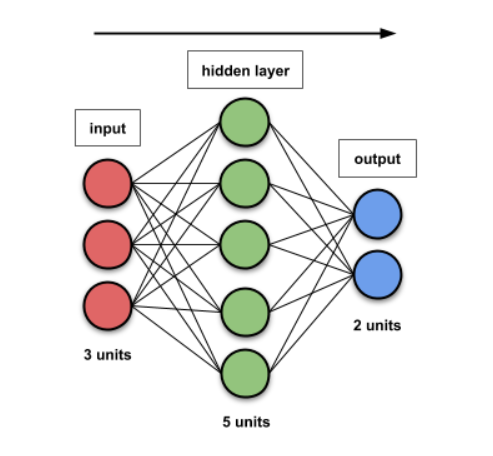

1. 정답
- 32개

2. 근거
- 입력층에서 은닉층으로의 파라미터: 20개
  - 가중치 파라미터: 15개
  - 바이어스 파라미터: 5개
- 은닉층에서 출력층으로의 파라미터: 12개
  - 가중치 파라미터: 10개
  - 바이어스 파라미터: 2개
- 총 파라미터: 32개
  - 입력층에서 은닉층으로의 파라미터(20개) + 은닉층에서 출력층으로의 파라미터(12개) = 32개


### Q2) Using the Gradient Descent Algorithm, the loss of the model will decrease continuously to a specific point, which is a minimum. Is it the optimal point? Why or why not?

1. 정답
- Gradient Descent 알고리즘이 손실 함수를 최소화하여 도달한 지점이 반드시 최적점이라고 할 수는 없다.

2. 근거
- 지역 최적점일 가능성 존재
  - Gradient Descent 알고리즘은 여러개의 최솟값을 가질 수 있으며, 도달한 지점이 전역 최적점이 아닌 지역 최적점일 가능성이 존재한다.
- 적정 학습률이 전제되었는가
  - Gradient Descent 알고리즘이 최적점에 도달하기 위해서는 적정한 학습률이 전제되어야 한다. 예를 들어 학습률이 낮은 경우 수렴 속도가 느리며, 높은 경우 최적점을 지나칠 수 있다. 따라서 학습률이 적정하지 않은 경우 도달한 곳이 최적점이 아닐 수 있다.


### Q3) Is it possible to decrease the training error to zero? *(Hint: Think about the Universal Approximation Theorem)


1. 정답
- 이론상으로는 가능하지만 실제 세계에서는 데이터의 문제로 training error를 0으로 줄이는 것은 불가능에 가깝다.

2. 근거
- Universal Approximation Theorem에 따르면 적절한 조건에서 충분히 복잡한 신경망은 임의의 연속 함수에 대해 원하는 정도의 정확도로 근사할 수 있다.
- 다만, 실제 세계에서 모델링을 진행할 때는 데이터에 노이즈나 잘못된 레이블이 포함돼 있을 수 있기 때문에 training error을 0으로 줄이는 것은 어렵다.

### Q4) Is deep learning the best method to build models? That is, does deeper networks generalize better than other methods? *(Hint: it is somehow related with question 3)*

1. 정답
- 딥러닝이 모든 경우에 가장 적합한 방법론이라 할 수는 없다.

2. 근거
- 마찬가지로 데이터에 따라 최적의 방법론이 달라진다고 생각한다.
- 데이터의 수가 부족하거나 노이즈가 많은 경우 오히려 전통적인 머신러닝 기법을 응용하여 활용하는 것이 더 좋은 성능을 낼 수 있다.